<h1 style="text-align: center; color: darkblue;">Experiment Dashboard</h1>


### model types at teh end


Intro

what dataset, goal, metric

Hyperparam analysis for each model

correlation heatmap

param vs metric plots

interaction plots

top trials

Best configuration per model

best params

learning curve

pred vs gt

error distribution

Comparison between model types

table of best results

barplot or line plot

final conclusion

### 📑 <font color='blue'> Table of Contents </font>
1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Results](#4) <br>
    4.1. [Model summary and configuration](#4.1) <br>
    4.2. [Validation performance](#4.2) <br>
    4.3. [Test performance](#4.3)


## <a id="1" style="color: darkred; text-decoration: none;">1. Introduction</a>

In this notebook, we’ll explore and visualize the results from multiple experiments to identify performance patterns across models and configurations. The goal is to gain insights such as which model type (e.g., MLP, GCN, SchNet) tend to perform best, and which hyperparameter ranges or combinations lead to consistently strong results. 


## <a id="2" style="color: darkred; text-decoration: none;">2. Setup </a>

In [18]:
import os, sys
sys.path.append(os.path.abspath("..")) # to be able to import src

import mlflow
from pathlib import Path

from mlflow.tracking import MlflowClient

In [8]:
EXPERIMENT_NAME="qm9" # later from conf

In [9]:
# mlflow tracking URI
mlflow_path = Path().resolve().parent / "mlflow.db"
mlflow.set_tracking_uri(f"sqlite:///{mlflow_path}")

## <a id="3" style="color: darkred; text-decoration: none;">3. Helper Functions </a>

In [10]:
# obengo todos los exps. de tuing
# luego filtro x modelo
# junto todos los trials de esos modelos (y el mejor modelo entrenado ciertos epochs)
# al final comparo las metricas entre los mejores modelos;: para idea del mejor modelo

In [21]:
def get_experiment_id_by_name(name):
    """get exp. id by name"""
    client = MlflowClient()
    exp = client.get_experiment_by_name(name)
    if exp is None:
        raise ValueError(f"Experiment '{name}' not found.")
    return exp.experiment_id


def get_run_data(run_id):
    """get data from a specific run"""
    client = MlflowClient()
    run = client.get_run(run_id)

    data = {
        "info": run.info,
        "params": run.data.params,
        "metrics": run.data.metrics,
        "tags": run.data.tags,
        "artifacts": {}
    }

    # download artifacts
    for a in client.list_artifacts(run_id):
        local_path = client.download_artifacts(run_id, a.path)
        data["artifacts"][a.path] = local_path

    return data


In [22]:
def get_exps(experiment_id, run_name='tuning'):
    """tuning experiments"""
    df = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string=(
            f"attributes.run_name = '{run_name}' "
        )
    )
    
    return df
    
    


In [83]:
exp_id = get_experiment_id_by_name(EXPERIMENT_NAME)

df = get_exps(exp_id)

In [85]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_rmse', 'metrics.val_r2', 'metrics.val_mae',
       'metrics.val_ev', 'metrics.val_mse', 'params.subset',
       'params.val_ratio', 'params.hidden', 'params.final_epochs',
       'params.target', 'params.epochs', 'params.batch_size',
       'params.final_lr', 'params.lr', 'params.num_atom_types',
       'params.num_interactions', 'params.final_epoch', 'params.num_gaussians',
       'params.cutoff', 'params.hidden_channels', 'params.num_filters',
       'params.readout', 'tags.mlflow.source.git.commit', 'tags.data_version',
       'tags.mlflow.runName', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.model_type', 'tags.mlflow.user'],
      dtype='object')

In [86]:
cols_to_keep = [
        'run_id', 
        'experiment_id',  
        'artifact_uri',  
        'metrics.val_rmse', 
        'metrics.val_r2', 
        'metrics.val_mae',
        'metrics.val_ev', 
        'metrics.val_mse', 
        'params.subset',
        'params.val_ratio', 
        'params.hidden', 
        'params.final_epochs',
        'params.target', 
        'params.epochs', 
        'params.batch_size',
        'params.final_lr', 
        'params.lr', 
        'params.num_atom_types',
        'params.num_interactions', 
        'params.final_epoch', 'params.num_gaussians',
        'params.cutoff', 
        'params.hidden_channels', 
        'params.num_filters',
        'params.readout',  
        'tags.data_version',
        'tags.model_type', 
        'tags.mlflow.user'
    
]

In [88]:
df = df[cols_to_keep]
df

,run_id,experiment_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,...,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type,tags.mlflow.user
0,40ba5ea3e4694a6e99a9b41a9aae1d91,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.109040,0.313641,0.835418,0.313825,1.229969,1000,0.2,...,None,None,None,None,None,None,None,v1,gcn,marcos
1,e48fc94bf00844a9a0b3c2d56485492d,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.139768,0.275080,0.877162,0.275952,1.299071,1000,0.2,...,None,None,None,None,None,None,None,v1,mlp,marcos
2,6657cf061e544f8eb2fc6a76d85b4cda,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.235786,0.147795,0.978362,0.149971,1.527168,1000,0.2,...,3,4,50,5.0,256,128,add,v1,schnet,marcos
3,bb4d5d1e9ad649f987c5597d4fd91aed,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.060443,0.372474,0.789215,0.373603,1.124539,1000,0.2,...,None,24,None,None,None,None,None,v1,mlp,marcos
4,e4982a54782b4c6c8e218bbbbd7050a0,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.983495,0.460239,0.726888,0.487832,0.967263,1000,0.2,...,3,4,50,5.0,128,128,add,v1,schnet,marcos
5,cc8b4924f2b94b45bed544cf7ad9b715,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.989939,0.453143,0.760950,0.472924,0.979979,1000,0.2,...,5,None,50,5.0,128,128,add,v1,schnet,marcos


In [92]:
# best per type

best_df = df.loc[df.groupby("tags.model_type")["metrics.val_mse"].idxmin()]
best_df

,run_id,experiment_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,...,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type,tags.mlflow.user
0,40ba5ea3e4694a6e99a9b41a9aae1d91,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.109040,0.313641,0.835418,0.313825,1.229969,1000,0.2,...,None,None,None,None,None,None,None,v1,gcn,marcos
3,bb4d5d1e9ad649f987c5597d4fd91aed,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.060443,0.372474,0.789215,0.373603,1.124539,1000,0.2,...,None,24,None,None,None,None,None,v1,mlp,marcos
4,e4982a54782b4c6c8e218bbbbd7050a0,1,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.983495,0.460239,0.726888,0.487832,0.967263,1000,0.2,...,3,4,50,5.0,128,128,add,v1,schnet,marcos


In [93]:
best_df.columns

Index(['run_id', 'experiment_id', 'artifact_uri', 'metrics.val_rmse',
       'metrics.val_r2', 'metrics.val_mae', 'metrics.val_ev',
       'metrics.val_mse', 'params.subset', 'params.val_ratio', 'params.hidden',
       'params.final_epochs', 'params.target', 'params.epochs',
       'params.batch_size', 'params.final_lr', 'params.lr',
       'params.num_atom_types', 'params.num_interactions',
       'params.final_epoch', 'params.num_gaussians', 'params.cutoff',
       'params.hidden_channels', 'params.num_filters', 'params.readout',
       'tags.data_version', 'tags.model_type', 'tags.mlflow.user'],
      dtype='object')

In [94]:
cols_to_keep_best = [
       'metrics.val_rmse',
       'metrics.val_r2', 'metrics.val_mae', 'metrics.val_ev',
       'metrics.val_mse',  
    'tags.model_type', 
]

best_df = best_df[cols_to_keep_best]

best_df
#best_df = best_df.sort_values("mse")

,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,tags.model_type
0,1.109040,0.313641,0.835418,0.313825,1.229969,gcn
3,1.060443,0.372474,0.789215,0.373603,1.124539,mlp
4,0.983495,0.460239,0.726888,0.487832,0.967263,schnet


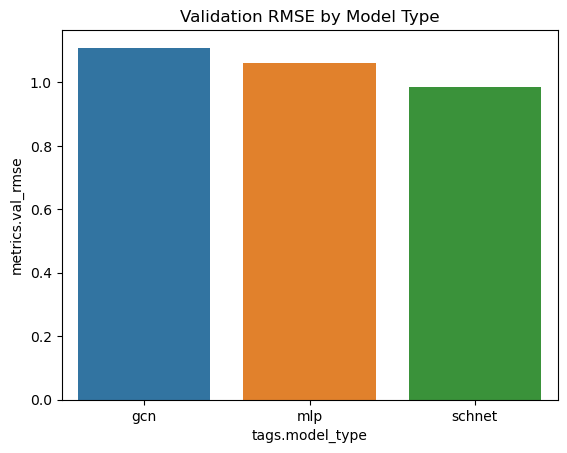

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=best_df, x="tags.model_type", y="metrics.val_rmse")
plt.title("Validation RMSE by Model Type")
plt.show()

#Do the same for R², MAE, MSE, EV.


✅ 2. Radar / Spider Plot (best for multi-metric comparison)

Let’s you see all metrics for each model in one visual.

Best when comparing multiple metrics at once.

Example code (normalizes metrics so they fit a 0-1 scale):

----
Why?
You directly see trade-offs:

model that has low RMSE but high MAE

best overall balance

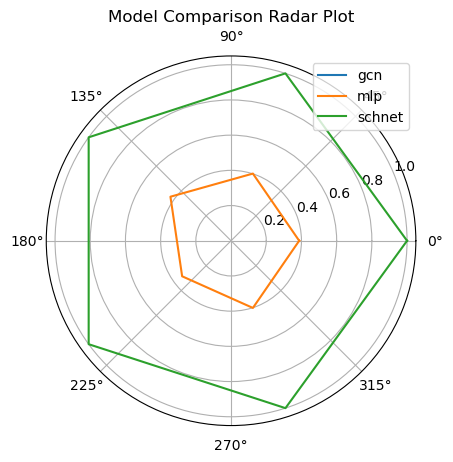

In [102]:
import numpy as np
import matplotlib.pyplot as plt


df = best_df

metrics = ["metrics.val_rmse", "metrics.val_r2", "metrics.val_mae", 
           "metrics.val_ev", "metrics.val_mse"]

#df_norm = df.copy()
#df_norm[metrics] = (df[metrics] - df[metrics].min()) / (df[metrics].max() - df[metrics].min())


# note mix gretare better with lowe better
df_norm = df.copy()

# metrics where HIGHER = better
higher_better = ["metrics.val_r2", "metrics.val_ev"]

# metrics where LOWER = better
lower_better = ["metrics.val_rmse", "metrics.val_mae", "metrics.val_mse"]

# normalize 0-1
for col in higher_better:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

for col in lower_better:
    df_norm[col] = (df[col].max() - df[col]) / (df[col].max() - df[col].min())




labels = metrics
num_vars = len(labels)

for idx, row in df_norm.iterrows():
    values = row[metrics].values.tolist()
    values += values[:1]  # close loop

    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.polar(angles, values, label=row["tags.model_type"])

plt.legend()
plt.title("Model Comparison Radar Plot")
plt.show()


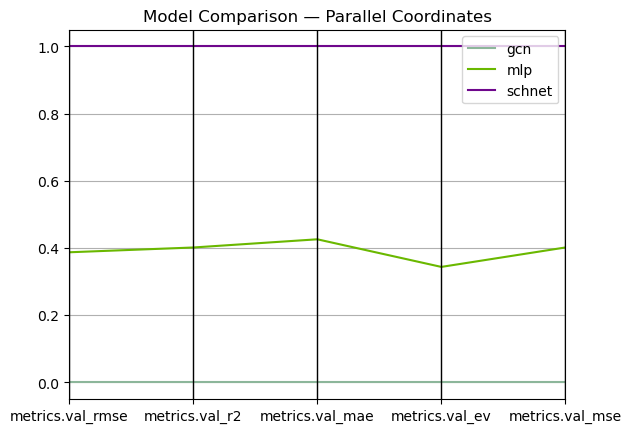

In [103]:
from pandas.plotting import parallel_coordinates

parallel_coordinates(df_norm, "tags.model_type")
plt.title("Model Comparison — Parallel Coordinates")
plt.show()

In [107]:
best_df

,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,tags.model_type
0,1.109040,0.313641,0.835418,0.313825,1.229969,gcn
3,1.060443,0.372474,0.789215,0.373603,1.124539,mlp
4,0.983495,0.460239,0.726888,0.487832,0.967263,schnet


In [104]:
df_norm

,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,tags.model_type
0,0.00000,0.000000,0.000000,0.000000,0.000000,gcn
3,0.38709,0.401324,0.425714,0.343536,0.401324,mlp
4,1.00000,1.000000,1.000000,1.000000,1.000000,schnet


In [105]:
"""
our DataFrame has only 3 model types, so for each metric:

gcn has the worst value → becomes 0.0

schnet has the best value → becomes 1.0

mlp is between them → becomes something like 0.38–0.42

This is exactly how min–max normalization works:

norm=x−min⁡max⁡−min⁡
norm=
max−min
x−min
	​


When you flip low-is-better metrics:

norm=max⁡−xmax⁡−min⁡
norm=
max−min
max−x
	​


With only 3 data points per metric, the result is always:

0.0 for the worst model

1.0 for the best model

a number between 0 and 1 for the middle model
"""

'\nour DataFrame has only 3 model types, so for each metric:\n\ngcn has the worst value → becomes 0.0\n\nschnet has the best value → becomes 1.0\n\nmlp is between them → becomes something like 0.38–0.42\n\nThis is exactly how min–max normalization works:\n\nnorm=x−min\u2061max\u2061−min\u2061\nnorm=\nmax−min\nx−min\n\t\u200b\n\n\nWhen you flip low-is-better metrics:\n\nnorm=max\u2061−xmax\u2061−min\u2061\nnorm=\nmax−min\nmax−x\n\t\u200b\n\n\nWith only 3 data points per metric, the result is always:\n\n0.0 for the worst model\n\n1.0 for the best model\n\na number between 0 and 1 for the middle model\n'

In [106]:
df

,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,tags.model_type
0,1.109040,0.313641,0.835418,0.313825,1.229969,gcn
3,1.060443,0.372474,0.789215,0.373603,1.124539,mlp
4,0.983495,0.460239,0.726888,0.487832,0.967263,schnet


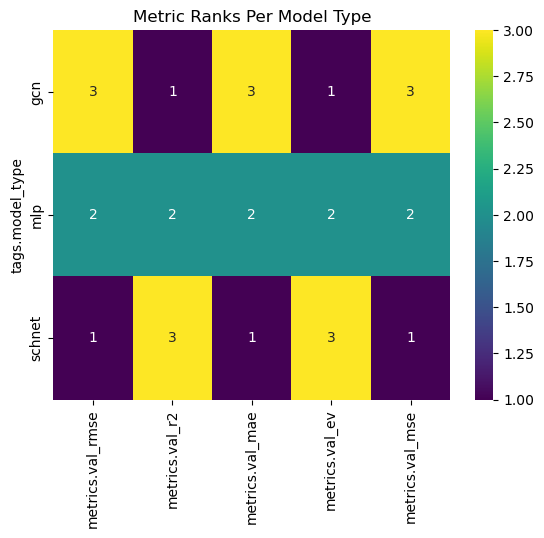

In [100]:
# check!!!!!!!!!!!!!!!!!!!!


rank_df = df.copy()
for m in metrics:
    rank_df[m] = rank_df[m].rank()

sns.heatmap(rank_df.set_index("tags.model_type")[metrics], annot=True, cmap="viridis")
plt.title("Metric Ranks Per Model Type")
plt.show()

In [ ]:
# drop undesired columns

# experiment_id, status,start_time, end_time, tags.mlflow.source.git.commit
#tags.mlflow.runName, tags.mlflow.source.name, tags.mlflow.source.type, tags.mlflow.user



In [25]:
cols_to_drop = [
    "experiment_id",
    "status",
    "start_time",
    "end_time",
    "tags.mlflow.source.git.commit",
    "tags.mlflow.runName",
    "tags.mlflow.source.name",
    "tags.mlflow.source.type",
    "tags.mlflow.user",
]

df = df.drop(columns=cols_to_drop, errors='ignore')


In [26]:
df

,run_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,params.hidden,...,params.num_atom_types,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type
0,40ba5ea3e4694a6e99a9b41a9aae1d91,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.109040,0.313641,0.835418,0.313825,1.229969,1000,0.2,128,...,100,None,None,None,None,None,None,None,v1,gcn
1,e48fc94bf00844a9a0b3c2d56485492d,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.139768,0.275080,0.877162,0.275952,1.299071,1000,0.2,512,...,100,None,None,None,None,None,None,None,v1,mlp
2,6657cf061e544f8eb2fc6a76d85b4cda,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.235786,0.147795,0.978362,0.149971,1.527168,1000,0.2,None,...,None,3,4,50,5.0,256,128,add,v1,schnet
3,bb4d5d1e9ad649f987c5597d4fd91aed,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.060443,0.372474,0.789215,0.373603,1.124539,1000,0.2,1024,...,100,None,24,None,None,None,None,None,v1,mlp
4,e4982a54782b4c6c8e218bbbbd7050a0,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.983495,0.460239,0.726888,0.487832,0.967263,1000,0.2,None,...,None,3,4,50,5.0,128,128,add,v1,schnet
5,cc8b4924f2b94b45bed544cf7ad9b715,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.989939,0.453143,0.760950,0.472924,0.979979,1000,0.2,None,...,None,5,None,50,5.0,128,128,add,v1,schnet


In [28]:
# get dfs per model type
dfs_by_model = {m: g for m, g in df.groupby("tags.model_type")}


In [31]:
dfs_by_model['schnet']

,run_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,params.hidden,...,params.num_atom_types,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type
2,6657cf061e544f8eb2fc6a76d85b4cda,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.235786,0.147795,0.978362,0.149971,1.527168,1000,0.2,None,...,None,3,4,50,5.0,256,128,add,v1,schnet
4,e4982a54782b4c6c8e218bbbbd7050a0,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.983495,0.460239,0.726888,0.487832,0.967263,1000,0.2,None,...,None,3,4,50,5.0,128,128,add,v1,schnet
5,cc8b4924f2b94b45bed544cf7ad9b715,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,0.989939,0.453143,0.760950,0.472924,0.979979,1000,0.2,None,...,None,5,None,50,5.0,128,128,add,v1,schnet


In [32]:
dfs_by_model['mlp']

,run_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,params.hidden,...,params.num_atom_types,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type
1,e48fc94bf00844a9a0b3c2d56485492d,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.139768,0.275080,0.877162,0.275952,1.299071,1000,0.2,512,...,100,None,None,None,None,None,None,None,v1,mlp
3,bb4d5d1e9ad649f987c5597d4fd91aed,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.060443,0.372474,0.789215,0.373603,1.124539,1000,0.2,1024,...,100,None,24,None,None,None,None,None,v1,mlp


In [33]:
dfs_by_model['gcn']

,run_id,artifact_uri,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,params.subset,params.val_ratio,params.hidden,...,params.num_atom_types,params.num_interactions,params.final_epoch,params.num_gaussians,params.cutoff,params.hidden_channels,params.num_filters,params.readout,tags.data_version,tags.model_type
0,40ba5ea3e4694a6e99a9b41a9aae1d91,/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/...,1.10904,0.313641,0.835418,0.313825,1.229969,1000,0.2,128,...,100,None,None,None,None,None,None,None,v1,gcn


In [34]:
# 

d = get_run_data('bb4d5d1e9ad649f987c5597d4fd91aed')

In [37]:
d

{'info': <RunInfo: artifact_uri='/home/marcos/Escritorio/AI-prod/QM9-ML/mlruns/1/bb4d5d1e9ad649f987c5597d4fd91aed/artifacts', end_time=1765409469602, experiment_id='1', lifecycle_stage='active', run_id='bb4d5d1e9ad649f987c5597d4fd91aed', run_name='tuning', start_time=1765409463606, status='FINISHED', user_id='marcos'>,
 'params': {'val_ratio': '0.2',
  'subset': '1000',
  'target': '0',
  'hidden': '1024',
  'num_atom_types': '100',
  'epochs': '24',
  'final_epoch': '24',
  'final_lr': '0.0010015886380446936',
  'lr': '0.0029200834928416724',
  'batch_size': '128'},
 'metrics': {'val_mse': 1.1245388984680176,
  'val_rmse': 1.0604428052902222,
  'val_mae': 0.7892153263092041,
  'val_r2': 0.3724743127822876,
  'val_ev': 0.3736029863357544},
 'tags': {'mlflow.user': 'marcos',
  'mlflow.source.name': '/home/marcos/Escritorio/AI-prod/QM9-ML/scripts/tuning.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.source.git.commit': 'ae01f124feee89221112d9a7d63bc69043e209db',
  'mlflow.runName': 'tun

In [40]:
trials_path = d['artifacts']['optuna_trials_ee9e73543e224519b2be8b4b5e371149.json']

In [41]:
import json

with open(trials_path, "r") as f:
    trials_data = json.load(f)

In [43]:
trials_data

[{'batch_size': 128,
  'lr': 0.0029200835,
  'hidden': 1024,
  'metrics': {'mse': 1.3450084925,
   'rmse': 1.159744978,
   'mae': 0.9430429339,
   'r2': 0.2494457364,
   'ev': 0.2694812417},
  'value': 1.3450086451,
  'number': 0},
 {'batch_size': 128,
  'lr': 0.000322736,
  'hidden': 256,
  'metrics': {'mse': 1.7089473009,
   'rmse': 1.3072670698,
   'mae': 1.0263059139,
   'r2': 0.0463572145,
   'ev': 0.0637228489},
  'value': 1.7089471626,
  'number': 1},
 {'batch_size': 256,
  'lr': 0.0007701725,
  'hidden': 1024,
  'metrics': {'mse': 1.4460549355,
   'rmse': 1.2025202513,
   'mae': 0.8941631913,
   'r2': 0.1930588484,
   'ev': 0.2655155659},
  'value': 1.4460549355,
  'number': 2}]

In [44]:
with open(trials_path, "r") as f:
    trials_data2 = json.load(f) 

In [ ]:
# por cada run en schnet_df
# obtengo el json de los trials
# lo giardo en una lista de jsons

In [52]:
df = dfs_by_model['schnet']


all_trials_schnet = []

for _, row in df.iterrows():
    print(row['run_id'])
    
    data = get_run_data(row['run_id'])
    
    artifacts = data["artifacts"]
    
    # get the json file (assuming only one)
    json_path = next(p for p in artifacts.values() if p.endswith(".json"))
    
    print(json_path)
    
    with open(json_path, "r") as f:
        data_trials = json.load(f)
    
    #all_trials_schnet.append(data_trials)
    for aux in data_trials:
        all_trials_schnet.append(aux)
    
    

6657cf061e544f8eb2fc6a76d85b4cda


/tmp/tmp7qq5g10_/optuna_trials_001a606b46364ae2b44cc4d3523a2b78.json
e4982a54782b4c6c8e218bbbbd7050a0


/tmp/tmpt9hf_3sm/optuna_trials_1203f348292749ee9c97be129dbf7eba.json
cc8b4924f2b94b45bed544cf7ad9b715


/tmp/tmp12h077ds/optuna_trials_09d81c0df6224fd9a8a7d0f36da06f15.json


In [55]:
all_trials_schnet



[{'batch_size': 32,
  'lr': 0.003682129,
  'hidden_channels': 256,
  'num_filters': 128,
  'num_interactions': 3,
  'metrics': {'mse': 1.3197768927,
   'rmse': 1.1488153934,
   'mae': 0.9487211704,
   'r2': 0.2635257244,
   'ev': 0.4127793908},
  'value': 1.3197769022,
  'number': 0},
 {'batch_size': 32,
  'lr': 0.0036046638,
  'hidden_channels': 128,
  'num_filters': 128,
  'num_interactions': 5,
  'metrics': {'mse': 2.1453919411,
   'rmse': 1.4647156,
   'mae': 1.2746132612,
   'r2': -0.197191596,
   'ev': 0.5316292644},
  'value': 2.145391922,
  'number': 1},
 {'batch_size': 32,
  'lr': 0.0004371863,
  'hidden_channels': 256,
  'num_filters': 128,
  'num_interactions': 6,
  'metrics': {'mse': 2.9247860909,
   'rmse': 1.7102005482,
   'mae': 1.4825525284,
   'r2': -0.632116437,
   'ev': 0.337158978},
  'value': 2.9247859955,
  'number': 2},
 {'batch_size': 16,
  'lr': 0.002910464,
  'hidden_channels': 128,
  'num_filters': 128,
  'num_interactions': 3,
  'metrics': {'mse': 1.04069566

In [58]:
import pandas as pd


df = pd.json_normalize(all_trials_schnet)  # your schnet list; normalizes to a lat list

df

,batch_size,lr,hidden_channels,num_filters,num_interactions,value,number,metrics.mse,metrics.rmse,metrics.mae,metrics.r2,metrics.ev
0,32,0.003682,256,128,3,1.319777,0,1.319777,1.148815,0.948721,0.263526,0.412779
1,32,0.003605,128,128,5,2.145392,1,2.145392,1.464716,1.274613,-0.197192,0.531629
2,32,0.000437,256,128,6,2.924786,2,2.924786,1.710201,1.482553,-0.632116,0.337159
3,16,0.002910,128,128,3,1.040696,0,1.040696,1.020145,0.826912,0.419261,0.468404
4,16,0.000218,256,128,4,1.376854,1,1.376855,1.173394,0.965935,0.231675,0.284081
5,32,0.000676,128,128,6,1.111393,2,1.111393,1.054226,0.846078,0.379810,0.412625
6,16,0.000189,128,128,3,1.015201,0,1.015201,1.007572,0.770612,0.433488,0.467380
7,16,0.001105,128,128,5,1.042867,1,1.042867,1.021209,0.779705,0.418050,0.449186
8,32,0.003719,128,128,5,0.840446,2,0.840446,0.916758,0.698928,0.531007,0.558077


In [59]:
# choose metric
df["target"] = df["metrics.mse"]


Correlation Heatmap

Good first pass. Helps you see which hyperparams actually influence the metric.

-----
You’ll quickly see things like:

    
check!!!!!
    
negative corr → good hyperparams

positive corr → bad hyperparams

near zero → irrelevant hyperparams

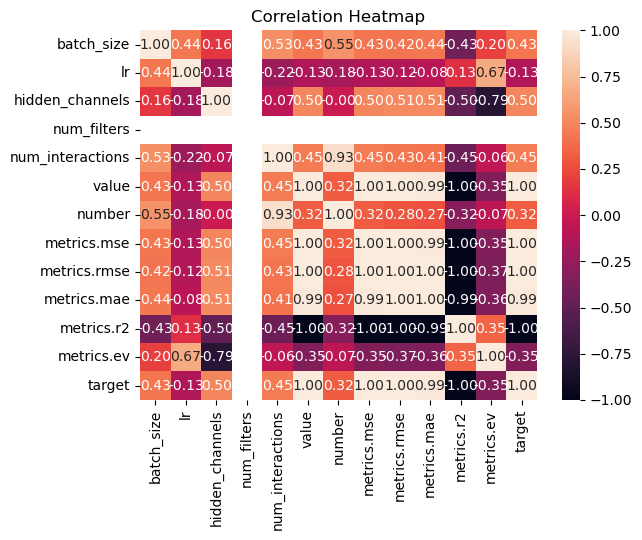

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# delete metrics in here!!!!!!!!!! (aybe io cna do it before)

sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Scatter plots: metric vs each hyperparam

This shows trends.


----------------
check!!!

Look for shapes:

U-shaped → sweet spot

downward trend → lower better

horizontal line → hyperparam irrelevant

<AxesSubplot:xlabel='lr', ylabel='target'>

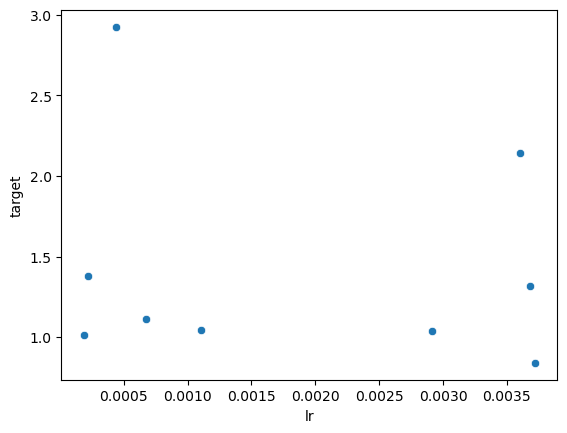

In [66]:

# colors!!!!!!!

sns.scatterplot(data=df, x="lr", y="target")
#sns.scatterplot(data=df, x="batch_size", y="target")
#sns.scatterplot(data=df, x="hidden_channels", y="target")


3. Hyperparameter interaction heatmaps

This is the best plot for tuning analysis.

Example: lr vs num_interactions, color = mse.

Text(0.5, 1.0, 'MAE by LR and Interactions')

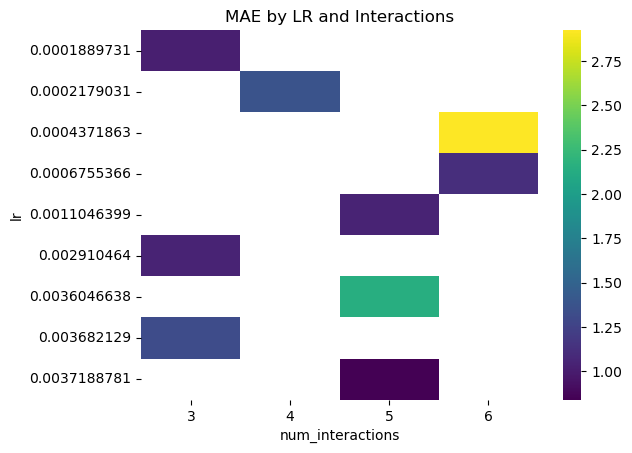

In [67]:
pivot = df.pivot_table(
    index="lr",
    columns="num_interactions",
    values="target",
    aggfunc="mean"
)

sns.heatmap(pivot, cmap="viridis")
plt.title("MAE by LR and Interactions")


Do this for any pair:

lr × hidden_channels

lr × num_filters

hidden_channels × num_interactions

This tells you which combinations are consistently good.

4. Parallel coordinate plot

Good for multi-dimensional pattern visualization.

This helps you see clusters of “good trial profiles”.

<AxesSubplot:>

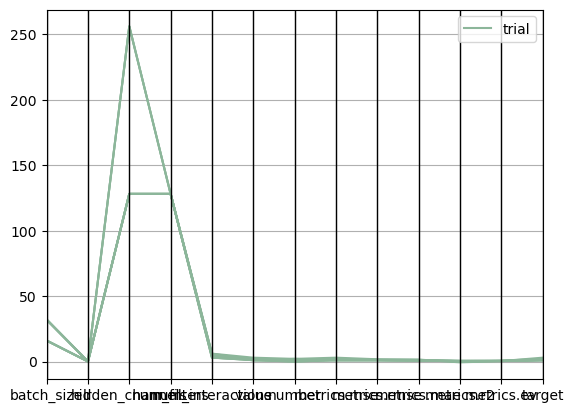

In [68]:
from pandas.plotting import parallel_coordinates

tmp = df.copy()
tmp["label"] = "trial"
parallel_coordinates(tmp, "label")


Look for repeating hyperparams:

lr always around same magnitude?

hidden_channels stable?

num_interactions always low/high?

This is how you detect “robust hyperparams”, not just lucky ones

In [70]:
df.sort_values("target").head(10)

,batch_size,lr,hidden_channels,num_filters,num_interactions,value,number,metrics.mse,metrics.rmse,metrics.mae,metrics.r2,metrics.ev,target
8,32,0.003719,128,128,5,0.840446,2,0.840446,0.916758,0.698928,0.531007,0.558077,0.840446
6,16,0.000189,128,128,3,1.015201,0,1.015201,1.007572,0.770612,0.433488,0.467380,1.015201
3,16,0.002910,128,128,3,1.040696,0,1.040696,1.020145,0.826912,0.419261,0.468404,1.040696
7,16,0.001105,128,128,5,1.042867,1,1.042867,1.021209,0.779705,0.418050,0.449186,1.042867
5,32,0.000676,128,128,6,1.111393,2,1.111393,1.054226,0.846078,0.379810,0.412625,1.111393
0,32,0.003682,256,128,3,1.319777,0,1.319777,1.148815,0.948721,0.263526,0.412779,1.319777
4,16,0.000218,256,128,4,1.376854,1,1.376855,1.173394,0.965935,0.231675,0.284081,1.376855
1,32,0.003605,128,128,5,2.145392,1,2.145392,1.464716,1.274613,-0.197192,0.531629,2.145392
2,32,0.000437,256,128,6,2.924786,2,2.924786,1.710201,1.482553,-0.632116,0.337159,2.924786


<AxesSubplot:xlabel='num_interactions', ylabel='target'>

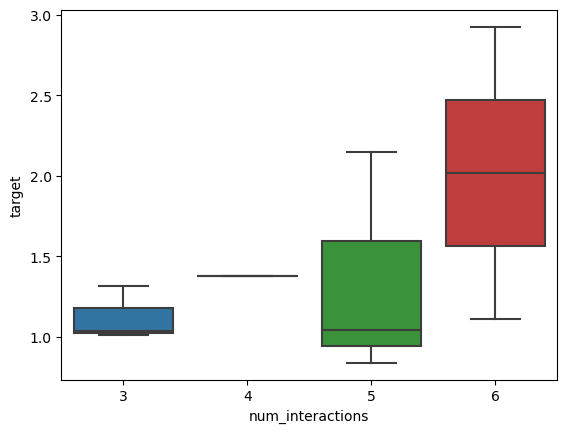

In [72]:
sns.boxplot(data=df, x="num_interactions", y="target")
#sns.boxplot(data=df, x="batch_size", y="target")


Correlation heatmap → what matters

Scatter plots → trends

2D heatmaps → interactions

Top 10 trials → stable patterns

### bets model for every run

In [76]:
dfs_by_model['schnet'].columns

Index(['run_id', 'artifact_uri', 'metrics.val_rmse', 'metrics.val_r2',
       'metrics.val_mae', 'metrics.val_ev', 'metrics.val_mse', 'params.subset',
       'params.val_ratio', 'params.hidden', 'params.final_epochs',
       'params.target', 'params.epochs', 'params.batch_size',
       'params.final_lr', 'params.lr', 'params.num_atom_types',
       'params.num_interactions', 'params.final_epoch', 'params.num_gaussians',
       'params.cutoff', 'params.hidden_channels', 'params.num_filters',
       'params.readout', 'tags.data_version', 'tags.model_type'],
      dtype='object')

In [82]:
aux = dfs_by_model['schnet']


cols_to_keep = [
    'metrics.val_rmse', 
    'metrics.val_r2',
    'metrics.val_mae',
    'metrics.val_ev', 
    'metrics.val_mse', 
    'tags.model_type'
]


vamos = aux[cols_to_keep]
vamos

,metrics.val_rmse,metrics.val_r2,metrics.val_mae,metrics.val_ev,metrics.val_mse,tags.model_type
2,1.235786,0.147795,0.978362,0.149971,1.527168,schnet
4,0.983495,0.460239,0.726888,0.487832,0.967263,schnet
5,0.989939,0.453143,0.760950,0.472924,0.979979,schnet


In [ ]:
# bets schnety vs bets_mlp vsa best_gcn

### more profesional way

In [ ]:
import json
import pandas as pd
from collections import defaultdict

# bucket for all trials grouped by "logical experiment"
bucket = defaultdict(list)

for _, row in df.iterrows():
    artifacts = row["artifacts"]
    json_path = next(p for p in artifacts.values() if p.endswith(".json"))

    # load trials (list)
    with open(json_path, "r") as f:
        trials = json.load(f)

    # normalize
    df_trials = pd.json_normalize(trials)

    # define your grouping key
    key = (row["model_type"], row["data_version"]) 
    # add more fields if needed

    # store it
    bucket[key].append(df_trials)

combined_trials = {
    key: pd.concat(dfs, ignore_index=True)
    for key, dfs in bucket.items()
}

{
  ("schnet", "v1"): df_with_all_trials_from_yesterday+today+other days,
  ("dimenet", "v1"): df_with_all_trials_from_multiple runs,
  ...
}

df_schnet = combined_trials[("schnet", "v1")]
df_dimenet = combined_trials[("dimenet", "v1")]
